<ipython-input-21-25fa2b4557bd>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  regression_data['total_bedrooms'].fillna(regression_data['total_bedrooms'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/g

                Model           RMSE        R²           MAE
0            Bayesian   71079.275876  0.614451  51832.943255
1    Gaussian(No Reg)  134798.866101 -0.386646  91261.604594
2  Gaussian(With Reg)  134798.864101 -0.386646  91261.602930
3       Ridge(No Reg)   71084.131168  0.614399  51835.734726
4     Ridge(With Reg)   71052.590524  0.614741  51817.477546


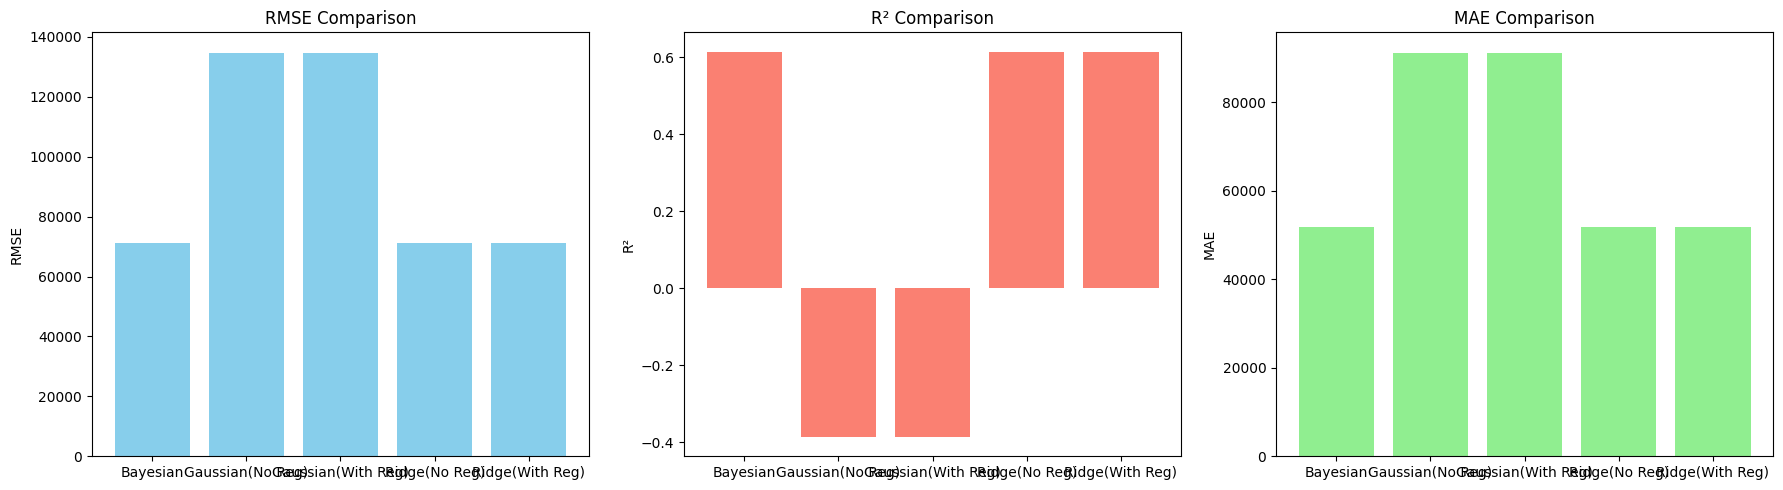

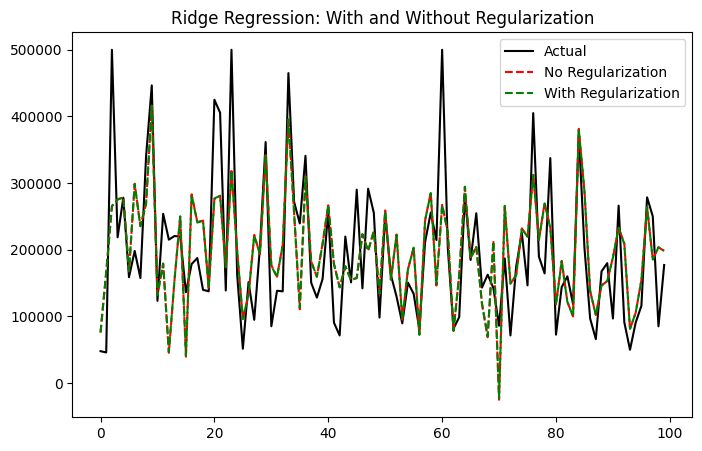

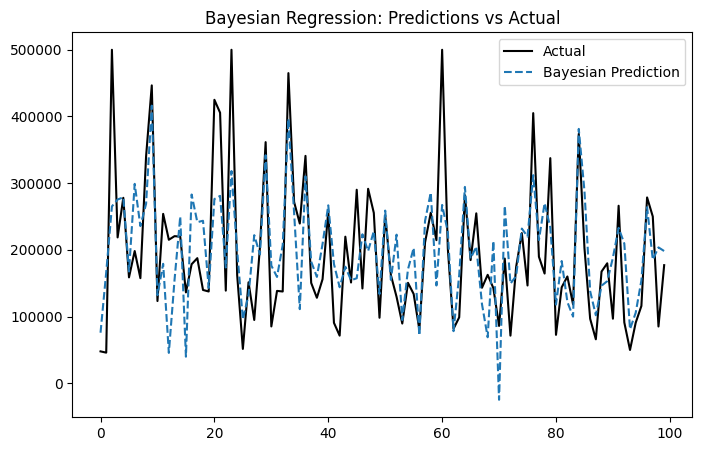

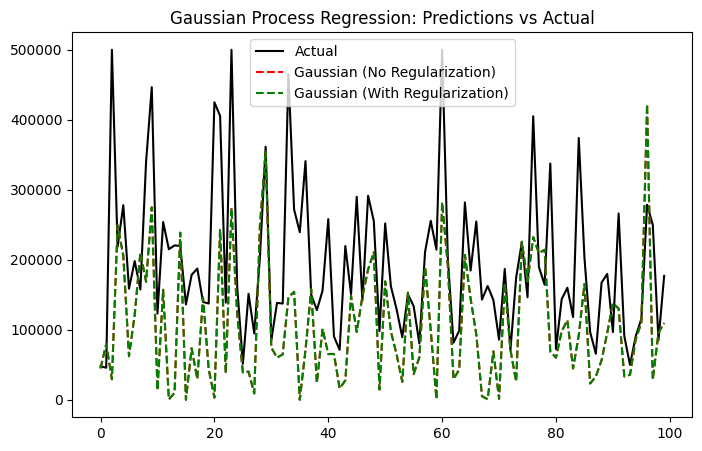

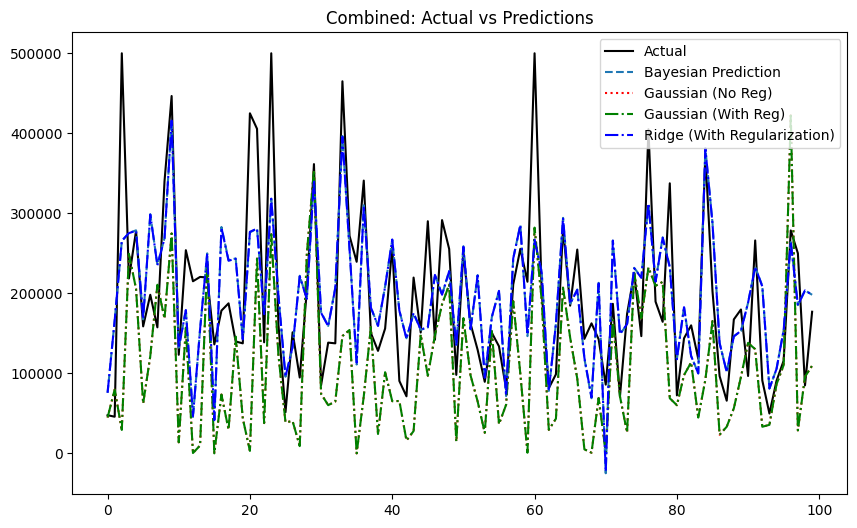

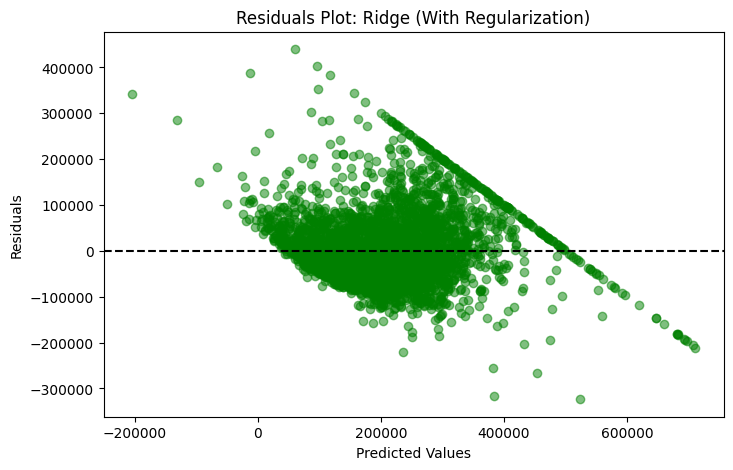

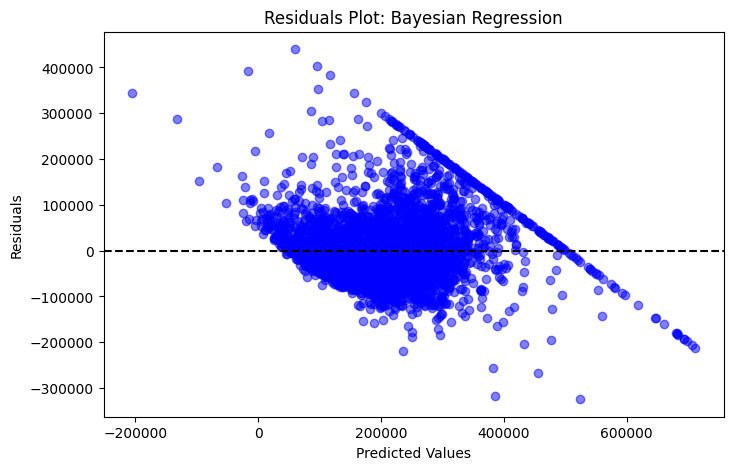

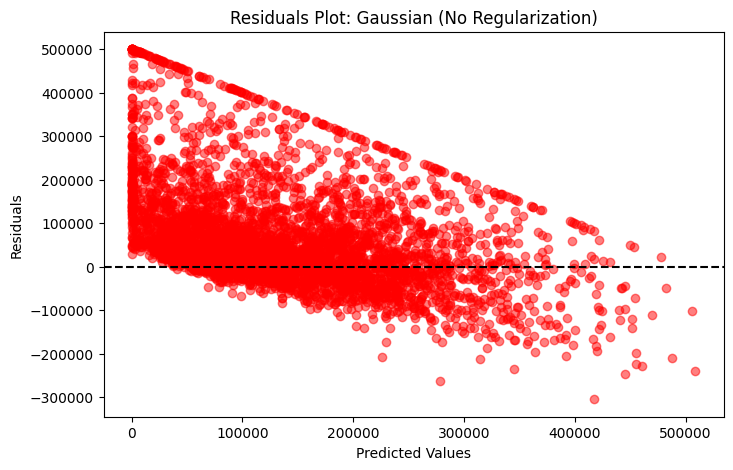

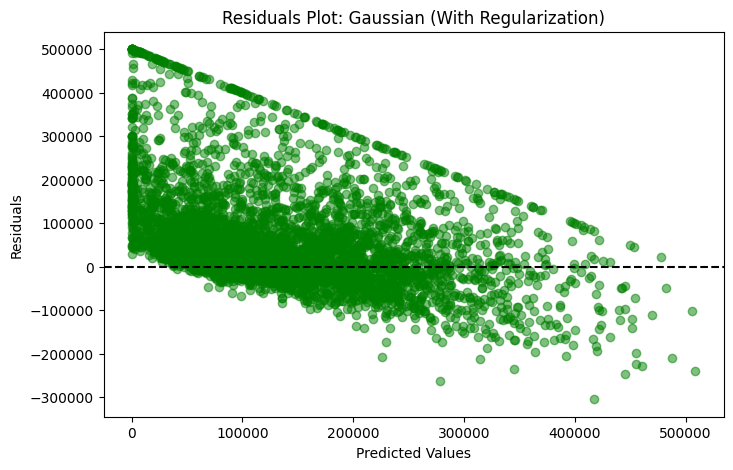

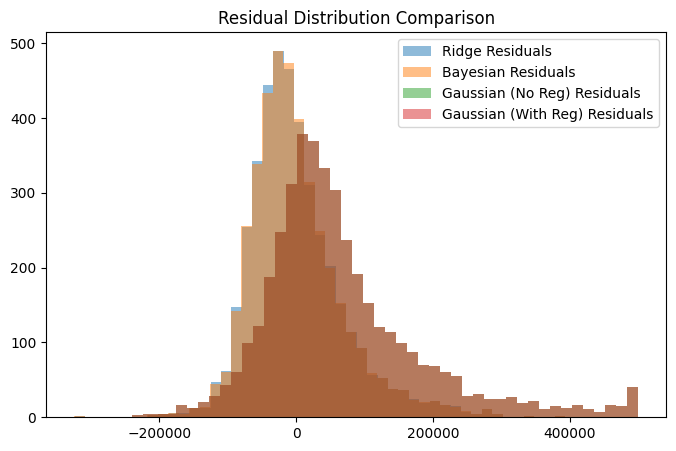

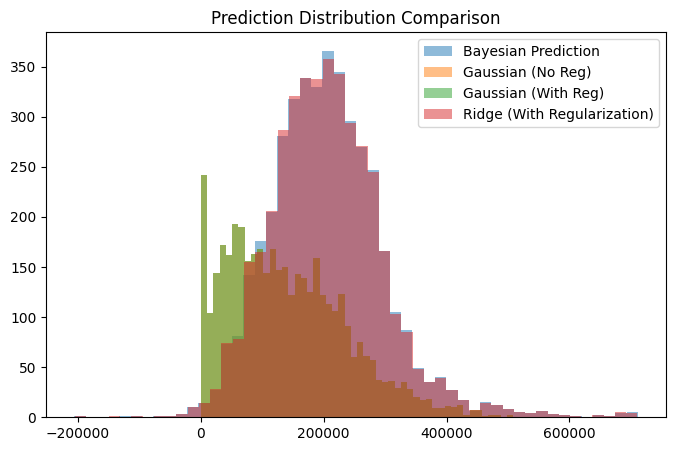

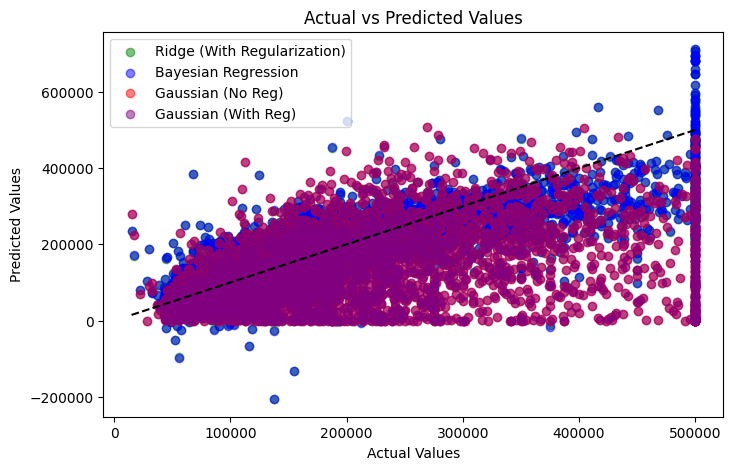

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Load and preprocess the dataset
regression_data = pd.read_csv('/content/housing.csv')  # Update the path if necessary
regression_data['total_bedrooms'].fillna(regression_data['total_bedrooms'].mean(), inplace=True)

X = regression_data.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = regression_data['median_house_value']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression: With and Without Regularization (Hyperparameter Tuning)
ridge_param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_grid_search = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)
ridge_best_model = ridge_grid_search.best_estimator_
ridge_no_reg = Ridge(alpha=0)  # No regularization
ridge_with_reg = ridge_best_model  # Best model from grid search

ridge_no_reg.fit(X_train, y_train)
ridge_with_reg.fit(X_train, y_train)

y_pred_no_reg = ridge_no_reg.predict(X_test)
y_pred_with_reg = ridge_with_reg.predict(X_test)

# Bayesian Regression
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)
y_pred_bayesian = bayesian_model.predict(X_test)

# Gaussian Process Regression: Without Regularization
kernel_no_reg = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gaussian_model_no_reg = GaussianProcessRegressor(kernel=kernel_no_reg, n_restarts_optimizer=10)
gaussian_model_no_reg.fit(X_train[:500], y_train[:500])  # Limiting data size for computational efficiency
y_pred_gaussian_no_reg = gaussian_model_no_reg.predict(X_test)

# Gaussian Process Regression: With Regularization (smaller length scale for RBF)
kernel_with_reg = C(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))  # Reduced length scale to regularize
gaussian_model_with_reg = GaussianProcessRegressor(kernel=kernel_with_reg, n_restarts_optimizer=10)
gaussian_model_with_reg.fit(X_train[:500], y_train[:500])  # Limiting data size for computational efficiency
y_pred_gaussian_with_reg = gaussian_model_with_reg.predict(X_test)

# Evaluate Models
models_regression = {
    "Bayesian": y_pred_bayesian,
    "Gaussian(No Reg)": y_pred_gaussian_no_reg,
    "Gaussian(With Reg)": y_pred_gaussian_with_reg,
    "Ridge(No Reg)": y_pred_no_reg,
    "Ridge(With Reg)": y_pred_with_reg
}

results = []
for name, preds in models_regression.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # Compute RMSE
    r2 = r2_score(y_test, preds)  # Compute R²
    mae = mean_absolute_error(y_test, preds)  # Compute MAE
    results.append([name, rmse, r2, mae])

# Create a DataFrame for model comparison
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²", "MAE"])

# Print model performance
print(results_df)

# Visualization: Comparison of Model Performances (RMSE, R², MAE)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
ax[0].bar(results_df["Model"], results_df["RMSE"], color="skyblue")
ax[0].set_title("RMSE Comparison")
ax[0].set_ylabel("RMSE")

# R²
ax[1].bar(results_df["Model"], results_df["R²"], color="salmon")
ax[1].set_title("R² Comparison")
ax[1].set_ylabel("R²")

# MAE
ax[2].bar(results_df["Model"], results_df["MAE"], color="lightgreen")
ax[2].set_title("MAE Comparison")
ax[2].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# Visualizations

# Ridge Regression: With and Without Regularization
plt.figure(figsize=(8, 5))
plt.plot(y_test.values[:100], label="Actual", color="black")
plt.plot(y_pred_no_reg[:100], label="No Regularization", color="red", linestyle="dashed")
plt.plot(y_pred_with_reg[:100], label="With Regularization", color="green", linestyle="dashed")
plt.title("Ridge Regression: With and Without Regularization")
plt.legend()
plt.show()

# Bayesian Regression
plt.figure(figsize=(8, 5))
plt.plot(y_test.values[:100], label="Actual", color="black")
plt.plot(y_pred_bayesian[:100], label="Bayesian Prediction", linestyle="dashed")
plt.title("Bayesian Regression: Predictions vs Actual")
plt.legend()
plt.show()

# Gaussian Regression: Without and With Regularization
plt.figure(figsize=(8, 5))
plt.plot(y_test.values[:100], label="Actual", color="black")
plt.plot(y_pred_gaussian_no_reg[:100], label="Gaussian (No Regularization)", linestyle="dashed", color="red")
plt.plot(y_pred_gaussian_with_reg[:100], label="Gaussian (With Regularization)", linestyle="dashed", color="green")
plt.title("Gaussian Process Regression: Predictions vs Actual")
plt.legend()
plt.show()

# Combined: Actual vs All Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual", color="black")
plt.plot(y_pred_bayesian[:100], label="Bayesian Prediction", linestyle="dashed")
plt.plot(y_pred_gaussian_no_reg[:100], label="Gaussian (No Reg)", linestyle="dotted", color="red")
plt.plot(y_pred_gaussian_with_reg[:100], label="Gaussian (With Reg)", linestyle="dashdot", color="green")
plt.plot(y_pred_with_reg[:100], label="Ridge (With Regularization)", linestyle="dashdot", color="blue")
plt.title("Combined: Actual vs Predictions")
plt.legend()
plt.show()

# Residuals Plot for Ridge (with regularization)
residuals_ridge = y_test - y_pred_with_reg
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_with_reg, residuals_ridge, alpha=0.5, color='green')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Residuals Plot: Ridge (With Regularization)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residuals Plot for Bayesian Regression
residuals_bayesian = y_test - y_pred_bayesian
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_bayesian, residuals_bayesian, alpha=0.5, color='blue')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Residuals Plot: Bayesian Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residuals Plot for Gaussian Regression (No Regularization)
residuals_gaussian_no_reg = y_test - y_pred_gaussian_no_reg
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_gaussian_no_reg, residuals_gaussian_no_reg, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Residuals Plot: Gaussian (No Regularization)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residuals Plot for Gaussian Regression (With Regularization)
residuals_gaussian_with_reg = y_test - y_pred_gaussian_with_reg
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_gaussian_with_reg, residuals_gaussian_with_reg, alpha=0.5, color='green')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("Residuals Plot: Gaussian (With Regularization)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residuals Distribution
plt.figure(figsize=(8, 5))
plt.hist(residuals_ridge, bins=50, alpha=0.5, label="Ridge Residuals")
plt.hist(residuals_bayesian, bins=50, alpha=0.5, label="Bayesian Residuals")
plt.hist(residuals_gaussian_no_reg, bins=50, alpha=0.5, label="Gaussian (No Reg) Residuals")
plt.hist(residuals_gaussian_with_reg, bins=50, alpha=0.5, label="Gaussian (With Reg) Residuals")
plt.legend()
plt.title("Residual Distribution Comparison")
plt.show()

# Prediction Distribution
plt.figure(figsize=(8, 5))
plt.hist(y_pred_bayesian, bins=50, alpha=0.5, label="Bayesian Prediction")
plt.hist(y_pred_gaussian_no_reg, bins=50, alpha=0.5, label="Gaussian (No Reg)")
plt.hist(y_pred_gaussian_with_reg, bins=50, alpha=0.5, label="Gaussian (With Reg)")
plt.hist(y_pred_with_reg, bins=50, alpha=0.5, label="Ridge (With Regularization)")
plt.legend()
plt.title("Prediction Distribution Comparison")
plt.show()

# Actual vs Predicted (Scatter Plot)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_with_reg, color="green", alpha=0.5, label="Ridge (With Regularization)")
plt.scatter(y_test, y_pred_bayesian, color="blue", alpha=0.5, label="Bayesian Regression")
plt.scatter(y_test, y_pred_gaussian_no_reg, color="red", alpha=0.5, label="Gaussian (No Reg)")
plt.scatter(y_test, y_pred_gaussian_with_reg, color="purple", alpha=0.5, label="Gaussian (With Reg)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="dashed")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()
